# Chapter 2 - Univariate Returns

In [1]:
%load_ext autoreload
%autoreload 2

## Load S&P 500 Data

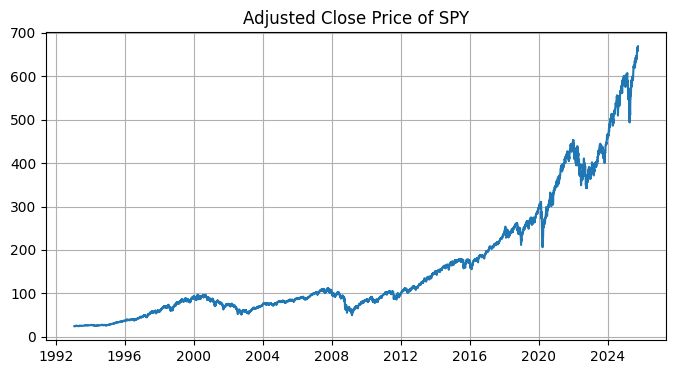

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def load_data():
    spx = yf.Ticker("SPY")
    hist = spx.history(start="1950-01-01", interval="1d", auto_adjust=False)
    return hist
data = load_data()
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(data["Adj Close"])
ax.set_title("Adjusted Close Price of SPY")
ax.grid()

## 2.1 Returns

## Return Definitions

**Return** is defined as:

$$r\left(1\right) := \frac{P\left(1\right) + D\left(1\right) - P\left(0\right)}{P\left(0\right)}$$

Where $P\left(t\right)$ is the price at time $t$ and $D\left(t\right)$ is the dividend (if any) at time $t$

**Excess Return** is defined as $r - r_f$ where $r_f$ is the risk free rate e.g. Secured Overnight Financing Rate (SOFR)

**Log Return** is defined as 

$$\tilde{r}_1 := \log\left(1+r_1\right)$$

## Return vs. Log Return

Three key points:

- Returns compounds to calculate cumulative returns, the distribution diverges from normal distribution when the single period return is close to normal distribution.

- On the other hand, log returns are additive over time, the distribution doesn't diverge much from normal distribution.

- By Taylor expansion, we get $\tilde{r} = r + o\left({\left|r\right|}^2\right)$. If $r$ is small, then $\tilde{r} \simeq r$. For daily interval measurement or shorter, the approximation is good. Therefore, longer period measurement may result in poor appoximation.

<span style="color:red;">However, from the test below, it seems log returns drift more away from normal distribution than returns. Maybe it's because the daily log returns and returns aren't normally distributed to start with?</span>

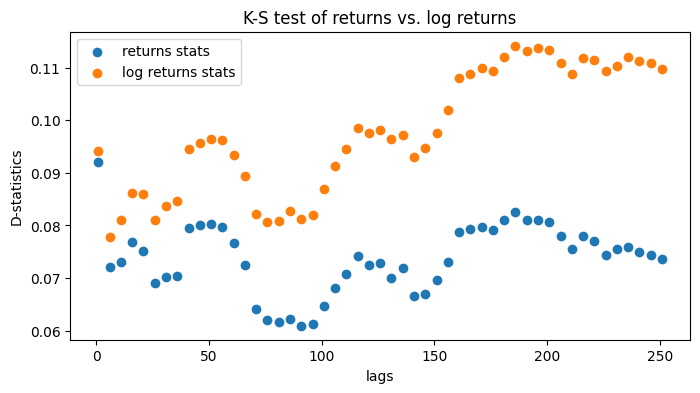

In [29]:
def calc_return(price, periods):
    return price[periods:] / price[:-periods] - 1

def calc_log_return(price, periods):
    return np.log(price[periods:] / price[:-periods])

def plot_hist_kde(data, ax):
    sns.kdeplot(data, linewidth=2, ax=ax)
    return ax
    

from scipy.stats import shapiro, kstest
import numpy as np

returns_stats = []
log_returns_stats = []
for lag in range(1, 252, 5):
    returns = calc_return(data["Adj Close"].values, lag)
    log_returns = calc_log_return(data["Adj Close"].values, lag)
    returns_stat, _ = kstest(returns, "norm", args=(np.mean(returns), np.std(returns)))
    log_returns_stat, _ = kstest(log_returns, "norm", args=(np.mean(log_returns), np.std(log_returns)))
    returns_stats.append(returns_stat)
    log_returns_stats.append(log_returns_stat)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.scatter(np.arange(1, 252, 5), returns_stats, label="returns stats")
ax.scatter(np.arange(1, 252, 5), log_returns_stats, label="log returns stats")
ax.set_xlabel("lags")
ax.set_ylabel("D-statistics")
ax.set_title("K-S test of returns vs. log returns")
ax.legend()

Let's try a toy model with log returns generated by the normal distribution $N(0, 0.01)$

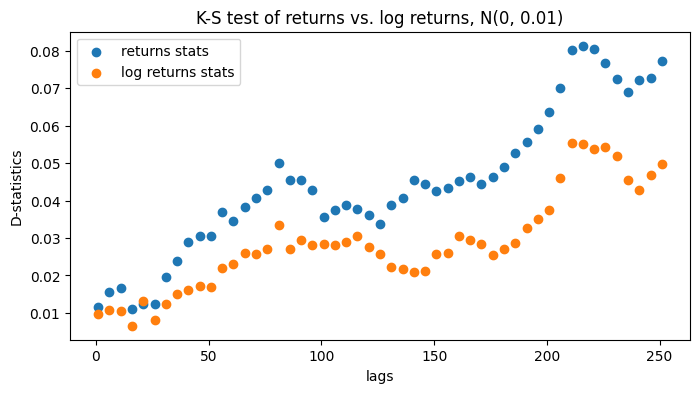

In [50]:
sim_log_returns = np.random.randn(5000)/100
sim_price = np.exp(np.cumsum(sim_log_returns))

returns_stats = []
log_returns_stats = []
for lag in range(1, 252, 5):
    returns = calc_return(sim_price, lag)
    log_returns = calc_log_return(sim_price, lag)
    returns_stat, _ = kstest(returns, "norm", args=(np.mean(returns), np.std(returns)))
    log_returns_stat, _ = kstest(log_returns, "norm", args=(np.mean(log_returns), np.std(log_returns)))
    returns_stats.append(returns_stat)
    log_returns_stats.append(log_returns_stat)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.scatter(np.arange(1, 252, 5), returns_stats, label="returns stats")
ax.scatter(np.arange(1, 252, 5), log_returns_stats, label="log returns stats")
ax.set_xlabel("lags")
ax.set_ylabel("D-statistics")
ax.set_title("K-S test of returns vs. log returns, N(0, 0.01)")
ax.legend()

Let's try another toy model with log returns generated by the normal distribution $N(0, 0.1)$

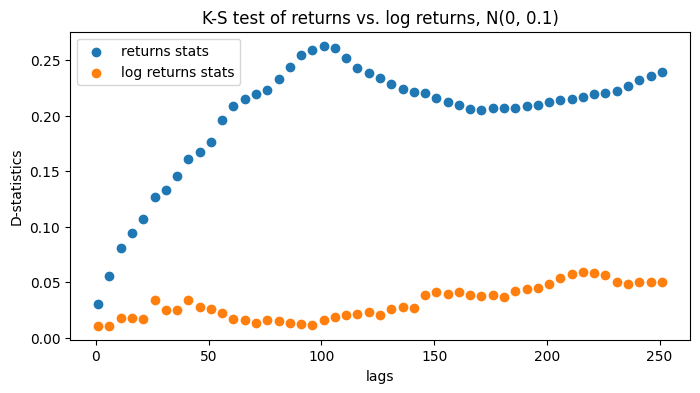

In [51]:
sim_log_returns = np.random.randn(5000)/10
sim_price = np.exp(np.cumsum(sim_log_returns))

returns_stats = []
log_returns_stats = []
for lag in range(1, 252, 5):
    returns = calc_return(sim_price, lag)
    log_returns = calc_log_return(sim_price, lag)
    returns_stat, _ = kstest(returns, "norm", args=(np.mean(returns), np.std(returns)))
    log_returns_stat, _ = kstest(log_returns, "norm", args=(np.mean(log_returns), np.std(log_returns)))
    returns_stats.append(returns_stat)
    log_returns_stats.append(log_returns_stat)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.scatter(np.arange(1, 252, 5), returns_stats, label="returns stats")
ax.scatter(np.arange(1, 252, 5), log_returns_stats, label="log returns stats")
ax.set_xlabel("lags")
ax.set_ylabel("D-statistics")
ax.set_title("K-S test of returns vs. log returns, N(0, 0.1)")
ax.legend()

Quote from section 2.1.3, page 24 "For long time intervals or very volatile returns, the approximation is poor". Log returns are more or less in line with returns's test stat as they both drift away from normal distribution with longer intervals when volatility is relatively low in N(0, 0.01). However, when switched to N(0, 0.1), returns start drifting a lot quickly compared to log returns. 

**To sum up, returns and log returns can be used interchangeably IF the volatility if low, otherwise, always use log returns.**